# The purpose of this notebook is to prep the raw data for citation network analyses

## Packages and Modules

In [11]:
# Data Manipulation
import pandas as pd 
import numpy as np 
import random

# Data visualization
import matplotlib.pyplot as plt 
import seaborn as sns 

# NLP
import nltk 
nltk.data.path.append("../models/")
from nltk.util import ngrams  
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import spacy
import re 

# Preferences
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## The dataset

In [215]:
raw_data = pd.read_csv("../data/02_intermediate/newlines_apos_removed_paragraphs_added.csv")
data = raw_data.copy()
data.sample(5)

,article_title,authors,abstract,full_text,citation_info,processed,paragraph
8224,ABA from A to Z: Behavior Science Applied to 3...,"William L. Heward,1 Thomas S. Critchfield,2 De...",The online version contains supplementary mate...,Perspectives on Behavior Science (2022) 45:327...,Perspect Behav Sci. 2022 Jun; 45(2): 327–359.,Perspectives on Behavior Science (2022) 45:327...,['Perspectives on Behavior Science (2022) 45:3...
2906,Technological behavior analysis and societal i...,Dennis H. Reid,NaN,"JOURNAL OF APPLIED BEHAVIOR ANALYSIS\n\n1991,2...",J Appl Behav Anal. 1991 Fall; 24(3): 437–439.,"JOURNAL OF APPLIED BEHAVIOR ANALYSIS 1991,2494...","['JOURNAL OF APPLIED BEHAVIOR ANALYSIS', '1991..."
6146,Effects of fixed-time shocks and brief stimuli...,Michael Keenan and Julian C. Leslie,When a fixed-time schedule of shocks was prese...,JOURNAL OF THE EXPERIMENTAL ANALYSIS OF BEHAVI...,J Exp Anal Behav. 1981 Nov; 36(3): 353–361.,JOURNAL OF THE EXPERIMENTAL ANALYSIS OF BEHAVI...,['JOURNAL OF THE EXPERIMENTAL ANALYSIS OF BEHA...
3392,Generalization of the effects of teacher- and ...,J W Fantuzzo and P W Clement,"Ten, black, second-grade boys served in a seri...","JOURNAL OF APPLIED BEHAVIOR ANALYSIS\n\n1981, ...",J Appl Behav Anal. 1981 Winter; 14(4): 435–447.,"JOURNAL OF APPLIED BEHAVIOR ANALYSIS 1981, 143...","['JOURNAL OF APPLIED BEHAVIOR ANALYSIS', '1981..."
5965,Choice between response units: The rate consta...,Michael D. Zeiler and Thomas F. Blakely,"In a conjoint schedule, reinforcement is avail...",JOURNAL OF THE EXPERIMENTAL ANALYSIS OF BEHAVI...,J Exp Anal Behav. 1983 Mar; 39(2): 275–291.,JOURNAL OF THE EXPERIMENTAL ANALYSIS OF BEHAVI...,['JOURNAL OF THE EXPERIMENTAL ANALYSIS OF BEHA...


In [216]:
# Isolate the journal names
journal_names = []
for citation in data['citation_info'].astype(str):
    # Find the year via regex
    match = re.search(r'\d{4}', citation)
    if match:
        end_index = match.start()
        journal_name = citation[:end_index].strip()
    else:
        journal_name = citation  # If no year is found, assume the whole string is the journal name

    journal_names.append(journal_name)

data['journal'] = journal_names
data['journal'].unique()

array(['Anal Verbal Behav.', 'nan', 'VB News.', 'Behav Anal Pract.',
       'J Appl Behav Anal.', 'J Exp Anal Behav.', 'Perspect Behav Sci.',
       'Behav Anal.'], dtype=object)

In [217]:
# Swap out the journal shorthand with an easier to use abbreviation
journal_dict = {
    'Anal Verbal Behav.': 'TAVB', 
    'VB News.': 'TAVB', 
    'Behav Anal Pract.': 'BAP', 
    'J Appl Behav Anal.': 'JABA', 
    'J Exp Anal Behav.': 'JEAB', 
    'Perspect Behav Sci.': 'PoBS', 
    'Behav Anal.': 'PoBS'
}
data['journal'] = data['journal'].map(journal_dict)
data['journal'].value_counts()

JEAB    4016
JABA    2855
PoBS    1135
BAP      827
TAVB     488
Name: journal, dtype: int64

In [ ]:
# Function to reverse a string
def reverse_string(s):
    return s[::-1]

# Function to find the last part of text after the last occurrence of 'reference'
def get_references_section(text):
    # First, try to remove the section about reception, revisions, and action editor
#     pattern = r"Received.*?(Final acceptance.*?|Action Editor.*?)?$"
#     text = re.sub(pattern, "", text, flags=re.DOTALL | re.IGNORECASE)
    
    # Reverse the text and the word 'reference'
    reversed_text = reverse_string(text.lower())
    reversed_word = reverse_string(" reference")

    # Find the index of the last occurrence of 'references'
    idx = reversed_text.find(reversed_word)

    # If 'references' is found, return the part after it; otherwise, return the original text
    if idx != -1:
        # Calculate the actual index in the original text
        actual_idx = len(text) - idx - len("reference")
        return text[actual_idx:].strip()
    else:
        return "None"
    
def remove_reference_prefix(text):
    pattern = r'^(References\s+|Reference\s+)'
    return re.sub(pattern, '', text, flags=re.IGNORECASE)

def remove_punctuation(text):
    text = re.sub(r"[^a-zA-Z0-9]"," ",text)
    return text

def find(s, ch):
    return [i for i, ltr in enumerate(s) if ltr == ch]

def split_at_period_near_colon(s):
    colon_indices = find(s, ':')
    split_indices = []

    for index in colon_indices:
        # Search for a period within the next 10 characters
        for i in range(index + 1, min(index + 21, len(s))):
            if s[i] == '.':
                split_indices.append(i+1)
                break

    # Split the string at each found period index
    splits = []
    start = 0
    for idx in split_indices:
        splits.append(s[start:idx + 1])  # Include the period in the split
        start = idx + 1

    # Add the remaining part of the string, if any
    if start < len(s):
        splits.append(s[start:])

    return splits

def split_references(text):
    # Patterns
    page_number_pattern = r'(\d{1,4}[-–—,]\s?\d{1,4})'
    doi_url_pattern = r'(doi:[^\s]+|http[^\s]+)'
    publisher_pattern = r'([A-Z][a-z]+\s?:\s[A-Z][a-zA-Z\s]+\.)(?=\s[A-Z][a-z]+|$)'
    combined_pattern = r'({}|{}|{})(?=\.\s+[A-Z]|$)'.format(page_number_pattern, doi_url_pattern, publisher_pattern)
    
    # Use combined_pattern to split references
    parts = re.split(combined_pattern, text)
    
    # Reassemble the split parts into complete references
    references = []
    i = 0
    while i < len(parts):
        if parts[i] is not None:
            combined = parts[i]
        else:
            combined = ''
        # Add the next part if it's not None
        if i + 1 < len(parts) and parts[i + 1] is not None:
            combined += parts[i + 1]
        combined = combined.strip()
        # Remove leading ". " if it exists
        if combined.startswith('. '):
            combined = combined[2:]
        references.append(combined)
        i += 2
    # Fallback method if initial pattern fails
    if not references:
        # Fallback pattern for older references
        fallback_pattern = r'\.\s+(?=[A-Z][a-z])'
        references = [ref.strip() for ref in re.split(fallback_pattern, text) if ref.strip()]
    # Remove all items in the list that are less than 15 characters long
    references = [ref for ref in references if len(ref) >=15]
    references = [ref for ref in references if not ref.startswith("https:")]
    references = [ref for ref in references if not ref.startswith("doi:")]
    
    clean_references = []
    
    for ref in references:
        split

In [384]:
# Function to reverse a string
def reverse_string(s):
    return s[::-1]

# Function to find the last part of text after the last occurrence of 'reference'
def get_references_section(text):
    # First, try to remove the section about reception, revisions, and action editor
#     pattern = r"Received.*?(Final acceptance.*?|Action Editor.*?)?$"
#     text = re.sub(pattern, "", text, flags=re.DOTALL | re.IGNORECASE)
    
    # Reverse the text and the word 'reference'
    reversed_text = reverse_string(text.lower())
    reversed_word = reverse_string(" reference")

    # Find the index of the last occurrence of 'references'
    idx = reversed_text.find(reversed_word)

    # If 'references' is found, return the part after it; otherwise, return the original text
    if idx != -1:
        # Calculate the actual index in the original text
        actual_idx = len(text) - idx - len("reference")
        return text[actual_idx:].strip()
    else:
        return "None"
    
def remove_reference_prefix(text):
    pattern = r'^(References\s+|Reference\s+)'
    return re.sub(pattern, '', text, flags=re.IGNORECASE)

def remove_punctuation(text):
    text = re.sub(r"[^a-zA-Z0-9]"," ",text)
    return text

def find(s, ch):
    return [i for i, ltr in enumerate(s) if ltr == ch]

def split_at_period_near_colon(s):
    colon_indices = find(s, ':')
    split_indices = []

    for index in colon_indices:
        # Search for a period within the next 10 characters
        for i in range(index + 1, min(index + 21, len(s))):
            if s[i] == '.':
                split_indices.append(i+1)
                break

    # Split the string at each found period index
    splits = []
    start = 0
    for idx in split_indices:
        splits.append(s[start:idx + 1])  # Include the period in the split
        start = idx + 1

    # Add the remaining part of the string, if any
    if start < len(s):
        splits.append(s[start:])

    return splits

def split_references(text):
    # Patterns
    page_number_pattern = r'(\d{1,4}[-–—,]\s?\d{1,4})'
    doi_url_pattern = r'(doi:[^\s]+|http[^\s]+)'
    publisher_pattern = r'([A-Z][a-z]+\s?:\s[A-Z][a-zA-Z\s]+\.)(?=\s[A-Z][a-z]+|$)'

    # Updated combined pattern to include a scenario where a period is directly followed by a capital letter
    combined_pattern = r'({}|{}|{})(?=\.\s*[A-Z]|$)'.format(page_number_pattern, doi_url_pattern, publisher_pattern)
    
    # Use combined_pattern to split references
    parts = re.split(combined_pattern, text)
    
    # Reassemble the split parts into complete references
    references = []
    i = 0
    while i < len(parts):
        if parts[i] is not None:
            combined = parts[i]
        else:
            combined = ''
            
        # Add the next part if it's not None
        if i + 1 < len(parts) and parts[i + 1] is not None:
            combined += parts[i + 1]
        combined = combined.strip()
        
        # Remove leading ". " if it exists
        if combined.startswith('. '):
            combined = combined[2:]
        references.append(combined)
        i += 2
        
    # Fallback method if initial pattern fails
    if not references:
        fallback_pattern = r'\.\s+(?=[A-Z][a-z])'
        references = [ref.strip() for ref in re.split(fallback_pattern, text) if ref.strip()]

    # Remove all items in the list that are less than 15 characters long
    references = [ref for ref in references if len(ref) >= 15]
    references = [ref for ref in references if not ref.startswith("https:")]
    references = [ref for ref in references if not ref.startswith("doi:")]
    
    # Final cleaning to catch publishers
    references = [val for ref in references for val in split_at_period_near_colon(ref)]

    return references

In [385]:
# Isolate the references section
new_col = []
for val in data['processed'].astype(str):
    references_section = get_references_section(val)
    references_section = remove_reference_prefix(references_section)
    new_col.append(references_section)

data['references'] = new_col
data['references'] = data['references'].astype(str)

In [386]:
# Isolate the individual references within the reference section well enough for analytics below
data['references_list'] = [split_references(val) for val in data['references']]

In [387]:
# rand_int = int(random.random()*len(data))
print(rand_int)
data.iloc[rand_int]['references_list']

5174


['(1959). Beecher, H. K. Measurement of subjective responses: Quantitative effects ofdrugs. New York: Oxford University Press. Burns, J. D., & Malone, J. C. (1992). The influence of preparedness on autoshaping, schedule performance, and choice. Journal of the Experimental Analysis of Behavior, 58, 399-413',
 'Chait, L. D., Uhlenhuth, E. H., & Johanson, C. E. (1985). The discriminative stimulus and subjective effects of d-amphetamine in humans. Pyschopharmacology, 86,',
 'Chait, L. D., Uhlenhuth, E. H., &Johanson, C. E. (1986). The discriminative stimulus and subjective effects of d-amphetamine, phenmetrazine and fenfluramine in humans. Pyschopharmacology, 89, 301-306',
 'Colpaert, F. C., Kuyps, M. D., Niemegeers, C. J. E., & Janssen, P. A. (1976). Discriminative stimulus properties of a low d,l-amphetamine dose. Archives Internationales de Pharmacodynamie et de Therapie, 223, 3442. (1987). Colpaert, F. C., Niemegeers, C. J. E., & Janssen, P. A. (1975). The narcotic cue: Evidence for th

## Counts of times each article cites within and outside BA journals

In [388]:
# Extract out the year ande decade from the citation_info
year = []
misses = []

for val in data['citation_info']:
    try:
        year.append(int(val.split(".")[1][1:5]))
    except:
        year.append(9999)
        misses.append(val)    
        
data['year'] = year
data['decade'] = data['year']/10
data['decade'] = data['decade'].astype(int)*10
data.sample(5)

,article_title,authors,abstract,full_text,citation_info,processed,paragraph,journal,references,references_list,year,decade,jaba_count,jeab_count,pobs_count,tavb_count,bap_count,within_ba,outside_ba
6307,Time-allocation matching between punishing sit...,Marvin Z. Deluty and Russell M. Church,"In the presence and absence of white noise, re...",JOURNAL OF THE EXPERIMENTAL ANALYSIS OF BEHAVI...,J Exp Anal Behav. 1978 Mar; 29(2): 191–198.,JOURNAL OF THE EXPERIMENTAL ANALYSIS OF BEHAVI...,['JOURNAL OF THE EXPERIMENTAL ANALYSIS OF BEHA...,JEAB,"Baum, W. M. The correlation-based law of effec...","[Baum, W. M. The correlation-based law of effe...",1978,1970,0,10,0,0,0,10,4
6835,Biorhythms in the activity of children during ...,"M. G. Wade, M. J. Ellis, and R. E. Bohrer",The interaction between the arousal to action ...,JOURNAL OF THE EXPERIMENTAL ANALYSIS OF BEHAVI...,J Exp Anal Behav. 1973 Jul; 20(1): 155–162.,JOURNAL OF THE EXPERIMENTAL ANALYSIS OF BEHAVI...,['JOURNAL OF THE EXPERIMENTAL ANALYSIS OF BEHA...,JEAB,"Asmussen, E. and Nielson, M. Cardiac output du...","[Asmussen, E. and Nielson, M. Cardiac output d...",1973,1970,0,0,0,0,0,0,9
5515,The application of Herrnstein's law of effect ...,B K Martens and J L Houk,The purpose of the present study was to evalua...,JOURNAL OF THE EXPERIMENTAL ANALYSIS OF BEHAVI...,J Exp Anal Behav. 1989 Jan; 51(1): 17–27.,JOURNAL OF THE EXPERIMENTAL ANALYSIS OF BEHAVI...,['JOURNAL OF THE EXPERIMENTAL ANALYSIS OF BEHA...,JEAB,"Baer, D. M. (1977). Reviewer's comment: Just b...","[Baer, D. M. (1977). Reviewer's comment: Just ...",1989,1980,10,14,0,0,0,24,7
7209,Tilted lines as complex stimuli1,Paul E. Touchette,Severely retarded boys were taught to respond ...,JOURNAL OF THE EXPERIMENTAL ANALYSIS OF BEHAVI...,J Exp Anal Behav. 1969 Mar; 12(2): 211–214.,JOURNAL OF THE EXPERIMENTAL ANALYSIS OF BEHAVI...,['JOURNAL OF THE EXPERIMENTAL ANALYSIS OF BEHA...,JEAB,"Bloomfield, T. M. Two types of behavioral cont...","[Bloomfield, T. M. Two types of behavioral con...",1969,1960,0,11,0,0,0,11,10
5646,Choice and foraging: the effects of accessibil...,E Fantino and R A Preston,Pigeons responded in a successive-encounters c...,JOURNAL OF THE EXPERIMENTAL ANALYSIS OF BEHAVI...,J Exp Anal Behav. 1988 Nov; 50(3): 395–403.,JOURNAL OF THE EXPERIMENTAL ANALYSIS OF BEHAVI...,['JOURNAL OF THE EXPERIMENTAL ANALYSIS OF BEHA...,JEAB,"Abarca, N., & Fantino, E. (1982). Choice and f...","[Abarca, N., & Fantino, E. (1982). Choice and ...",1988,1980,0,10,0,0,0,10,10


In [389]:
# Get counts of citations within each journal within each article
jaba_count = []
jeab_count = []
pobs_count = []
tavb_count = []
bap_count = []
within_ba = []
outside_ba = []

for article in data['references_list']:
    jaba = 0
    jeab = 0
    pobs = 0
    tavb = 0
    bap = 0
    outside = 0
    for ref in article:
        ref = str(ref).lower()
        ref = re.sub(r'[^\w\s]', '', ref)
        ref = ref.replace(" ", "")
        if ("appliedbehavioranalysis" in ref) or ("japplbehavanal" in ref):
            jaba+=1
        if ("experimentalanalysisofbehavior" in ref) or ("jexpanalbehav" in ref):
            jeab+=1
        if ("perspectivesonbehaviorscience" in ref) or ("thebehavioranalyst" in ref) or ("perspectbehavsci" in ref) or ("behavanal" in ref):
            pobs+=1
        if ("analysisofverbalbehavior" in ref) or ("analverbalbehav" in ref):
            tavb+=1
        if ("behavioranalysisinpractice" in ref) or ("behavanal" in ref):
            bap+=1
    jaba_count.append(jaba)
    jeab_count.append(jeab)
    pobs_count.append(pobs)
    tavb_count.append(tavb)
    bap_count.append(bap)
    all_ba = jaba+jeab+pobs+tavb+bap
    within_ba.append(all_ba)
    outside_ba.append(len(article)-all_ba)
    
data['jaba_count'] = jaba_count
data['jeab_count'] = jeab_count
data['pobs_count'] = pobs_count
data['tavb_count'] = tavb_count
data['bap_count'] = bap_count
data['within_ba'] = within_ba
data['outside_ba'] = outside_ba

In [390]:
plot_df = data[
    (data['year']!=9999) & (data['references']!="None") & (data['year']<2023)]\
    [['year', 'within_ba', 'outside_ba']].melt(id_vars='year')
plot_df['year'] = plot_df['year'].astype(int)

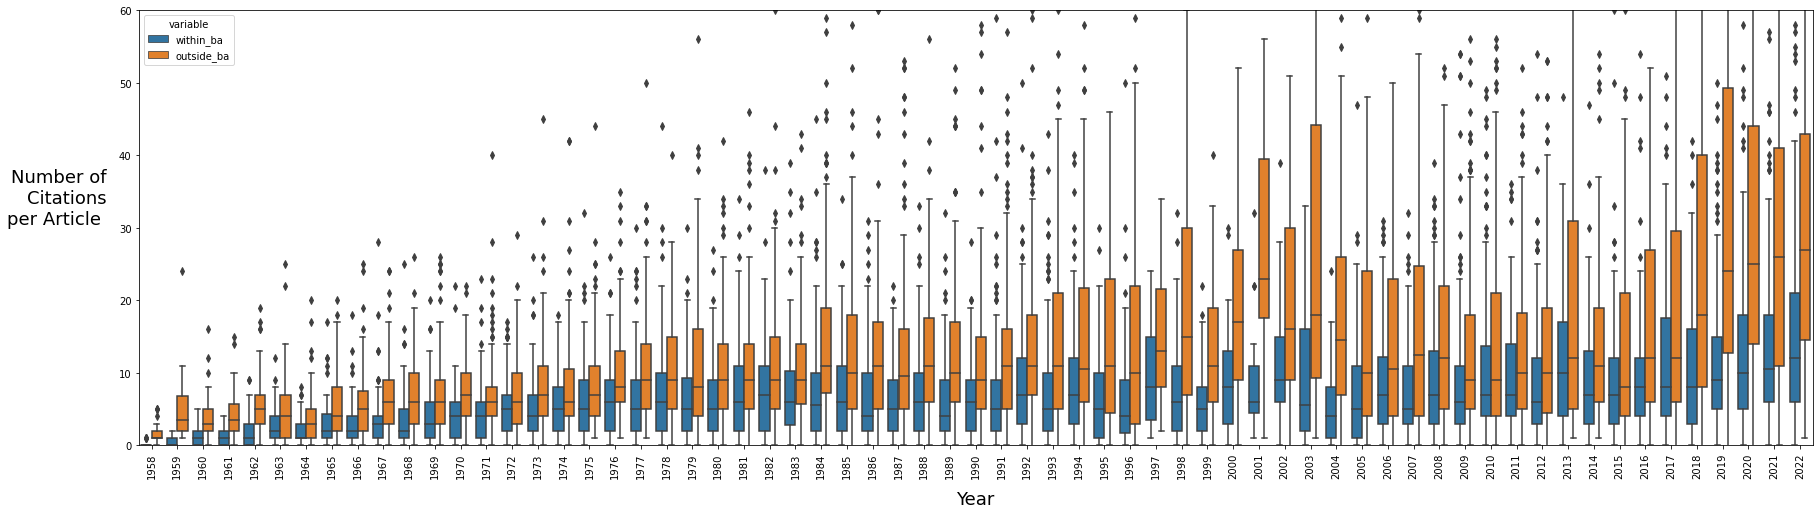

In [395]:
fig, ax = plt.subplots(figsize=(30, 8))
sns.boxplot(x='year', y='value', data=plot_df, hue='variable')
plt.xlabel("Year", fontsize=18, labelpad=12)
plt.ylabel("Number of\nCitations\nper Article ", fontsize=18, labelpad=12, rotation=0, ha="right")
plt.xticks(rotation=90)
plt.ylim(0, 60)
plt.show()

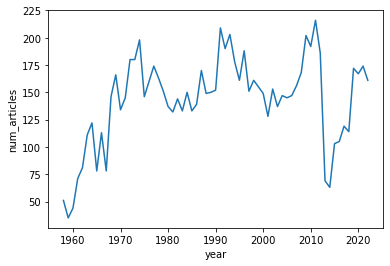

In [410]:
plot_df = data[(data['year']!=9999) & (data['year']<2023)]['year'].value_counts().reset_index().sort_values(by=['index'], ascending=True)
plot_df.columns = ['year', 'num_articles']
sns.lineplot(x=plot_df['year'], y=plot_df['num_articles'])
plt.show()

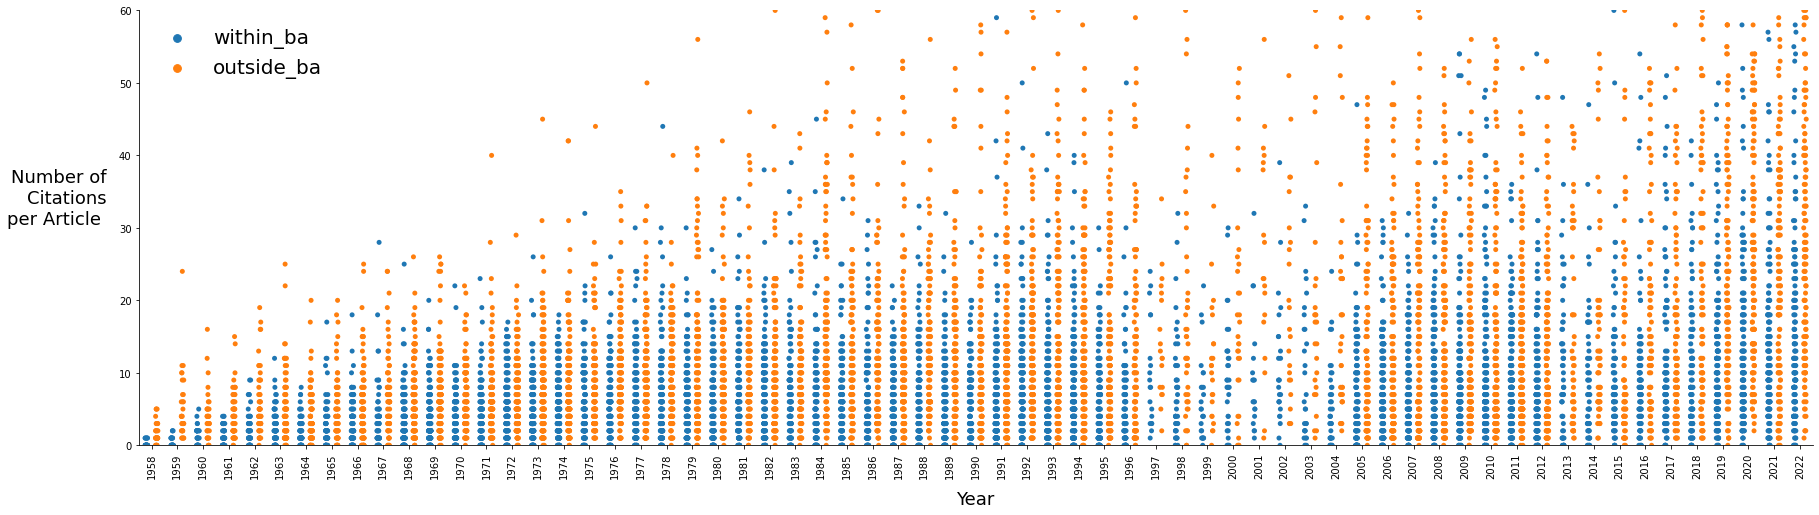

In [398]:
fig, ax = plt.subplots(figsize=(30, 8))
sns.stripplot(x='year', y='value', data=plot_df, hue='variable', dodge=True)
# sns.lineplot(x='year', y='value', data=plot_df, hue='variable')
plt.xlabel("Year", fontsize=18, labelpad=12)
plt.ylabel("Number of\nCitations\nper Article ", fontsize=18, labelpad=12, rotation=0, ha="right")
plt.xticks(rotation=90)
plt.ylim(0, 60)
sns.despine(top=True, right=True)
plt.legend(fontsize=20, frameon=False)
plt.show()

In [317]:
fix_df = data[(data['year']<2005) & (data['year']>1996) & (data['within_ba']==0)].reset_index(drop=True)
fix_df

,article_title,authors,abstract,full_text,citation_info,processed,paragraph,journal,references,references_list,year,decade,jaba_count,jeab_count,pobs_count,tavb_count,bap_count,within_ba,outside_ba
0,Towards a balanced account of autism etiology,Genae A. Hall,Drash and Tudor describe six sets of reinforce...,"The Analysis ofVerbal Behavior\n\n2004, 20, 37...",Anal Verbal Behav. 2004; 20: 37–43.,"The Analysis ofVerbal Behavior 2004, 20, 37-43...","['The Analysis ofVerbal Behavior', '2004, 20, ...",TAVB,"Barkley, Russell A. (2000). Taking charge of A...","[Barkley, Russell A. (2000). Taking charge of ...",2004,2000,0,0,0,0,0,0,4
1,Commentary on Drash and Tudor: An analysis of ...,Raymond G. Romanczyk and Jennifer M. Gillis,A critique is presented of the etiological mod...,"The Analysis ofVerbal Behavior\n\n2004, 20, 45...",Anal Verbal Behav. 2004; 20: 45–47.,"The Analysis ofVerbal Behavior 2004, 20, 45-47...","['The Analysis ofVerbal Behavior', '2004, 20, ...",TAVB,"Gillberg, C. (2000). The Biology ofthe Autisti...","[Gillberg, C. (2000). The Biology ofthe Autist...",2004,2000,0,0,0,0,0,0,2
2,Autism as a contingency-shaped disorder of ver...,Michael D. Hixson,Drash and Tudor's argument that autism is a co...,"The Analysis ofVerbal Behavior\n\n2004, 20, 49...",Anal Verbal Behav. 2004; 20: 49–53.,"The Analysis ofVerbal Behavior 2004, 20, 49-53...","['The Analysis ofVerbal Behavior', '2004, 20, ...",TAVB,American Psychological Association (2001). Pub...,[American Psychological Association (2001). Pu...,2004,2000,0,0,0,0,0,0,9
3,Notation systems for reading and writing sign ...,Amy L. McCarty,"Without written forms, signed languages do not...","The Analysis of Verbal Behavior\n\n2004, 20, 1...",Anal Verbal Behav. 2004; 20: 129–134.,"The Analysis of Verbal Behavior 2004, 20, 129-...","['The Analysis of Verbal Behavior', '2004, 20,...",TAVB,"Battison, R. (1974). Phonological deletion in ...","[Battison, R. (1974). Phonological deletion in...",2004,2000,0,0,0,0,0,0,2
4,Dedication: Ullin place: 1924–2000,David C. Palmer,NaN,"The Analysis of Verbal Behavior\n\n2000, 17, 5...",Anal Verbal Behav. 2000; 17: 5.,"The Analysis of Verbal Behavior 2000, 17, 5 DE...","['The Analysis of Verbal Behavior', '2000, 17,...",TAVB,"Place, U. T (1992). Eliminative connectionism ...","[Place, U. T (1992). Eliminative connectionism...",2000,2000,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,Behavioral pragmatism: No place for reality an...,Dermot Barnes-Holmes,The current article begins by reviewing L. J. ...,"The Behavior Analyst\n\n2000, 23, 191-202\n\nN...",Behav Anal. 2000 Fall; 23(2): 191–202.,"The Behavior Analyst 2000, 23, 191-202 No. 2 (...","['The Behavior Analyst', '2000, 23, 191-202', ...",PoBS,"reference. La Salle, IL: Open Court. Quine, W....","[reference. La Salle, IL: Open Court. Quine, W...",2000,2000,0,0,0,0,0,0,2
961,"An interview with W. N. Schoenfeld (july 22, 1...",Emilio Ribes-Iñesta,This article is a transcription of an intervie...,"The Behavior Analyst\n\n1999, 22, 123-130\n\nN...",Behav Anal. 1999 Fall; 22(2): 123–130.,"The Behavior Analyst 1999, 22, 123-130 No. 2 (...","['The Behavior Analyst', '1999, 22, 123-130', ...",PoBS,"Bridgman, P. W. (1945). Some general principle...","[Bridgman, P. W. (1945). Some general principl...",1999,1990,0,0,0,0,0,0,6
962,Beyond equality: A reply to Rakos,Lawrence E. Fraley,NaN,"The Behavior Analyst\n\n1998, 21, 33-35\n\nNo....",Behav Anal. 1998 Spring; 21(1): 33–35.,"The Behavior Analyst 1998, 21, 33-35 No. 1 (Sp...","['The Behavior Analyst', '1998, 21, 33-35', 'N...",PoBS,"Skinner, B. F (1971). Beyondfreedom and dignit...","[Skinner, B. F (1971). Beyondfreedom and digni...",1998,1990,0,0,0,0,0,0,1
963,"Skinner may be difficult, but..",David W. Schaal,NaN,"The Behavior Analyst\n\n1998, 21, 97-101\n\nNo...",Behav Anal. 1998 Spring; 21(1): 97–101.,"The Behavior Analyst 1998, 21, 97-101 No. 1 (S...","['The Behavior Analyst', '1998, 21, 97-101', '..."

In [414]:
rand_int = int(random.random()*len(fix_df))
print(rand_int)
fix_df.iloc[rand_int]

754


article_title      Progressive-ratio schedules: effects of later ...
authors                                       A Baron and  A Derenne
abstract           Four rats were studied with variants of a prog...
full_text                                                        NaN
citation_info           J Exp Anal Behav. 2000 May; 73(3): 291–304. 
processed                                                        NaN
paragraph                                                        NaN
journal                                                         JEAB
references                                                      None
references_list                                                   []
year                                                            2000
decade                                                          2000
jaba_count                                                         0
jeab_count                                                         0
pobs_count                        

In [415]:
fix_df.isna().sum()

article_title        0
authors              0
abstract           233
full_text          771
citation_info        0
processed          771
paragraph          771
journal              0
references           0
references_list      0
year                 0
decade               0
jaba_count           0
jeab_count           0
pobs_count           0
tavb_count           0
bap_count            0
within_ba            0
outside_ba           0
dtype: int64

## Create a matrix of the count of each article being cited within the others

In [ ]:
# # Lowercase the titles and references once
# data['references'] = data['references'].str.lower()

# # Create a dictionary to hold the data
# cite_data = {}

# # Get unique titles
# unique_titles = data['article_title'].unique()
# total_titles = len(unique_titles)

# # Loop through unique titles
# for index, title in enumerate(unique_titles, 1):
    
#     # Escape any special characters in the title for regular expression
#     escaped_title = re.escape(title)

#     # Use vectorized string contains method with the escaped title
#     cite_data[title] = data['references'].str.contains(escaped_title, regex=True).astype(int)

#     # Print progress update every 50 articles
#     if index % 50 == 0 or index == total_titles:
#         clear_output()
#         print(f"Processed {index} of {total_titles} titles.")

# # Convert the dictionary to a DataFrame
# cite_matrix = pd.DataFrame(cite_data)

In [79]:
# Lowercase the titles and references once
data['article_title'] = data['article_title'].str.lower()

# Remove period from the end of article_title
data['article_title'] = data['article_title'].str.replace('\.$', '', regex=True)

# Remove question mark from the end of article_title
data['article_title'] = data['article_title'].str.replace('\?$', '', regex=True)

# Remove comma from the end of article_title
data['article_title'] = data['article_title'].str.replace(', $', '', regex=True)

# Some titles have '1' at the end. Fix that. 
data['article_title'] = data['article_title'].str.replace('1$', '', regex=True)

# Some titles have '1,2' at the end. Fix that. 
data['article_title'] = data['article_title'].str.replace('1,2$', '', regex=True)

# Escape special characters in titles for regex
data['escaped_title'] = data['article_title'].apply(re.escape)

In [83]:
# Need to check the article_title column for anything that needs fixed because ambiguous
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 300)
df[df['article_title'].apply(lambda x: len(x)<15)][['article_title', 'citation_info']]

,article_title,citation_info
23,jack and me,Anal Verbal Behav. 2021 Dec; 37(2): 266–271.
125,editorial,Anal Verbal Behav. 2017 Oct; 33(2): 177–178.
460,a fable,Anal Verbal Behav. 1988; 6: 1–2.
470,lying,Anal Verbal Behav. 1989; 7: 43–47.
948,why wiba?,Behav Anal Pract. 2019 Dec; 12(4): 810–815.
984,"research, etc.",Behav Anal Pract. 2018 Sep; 11(3): 187–188.
1078,encore,Behav Anal Pract. 2016 Mar; 9(1): 1–2.
1222,skills™,Behav Anal Pract. 2013 Spring; 6(1): 96–100.
1235,ablls-r kit,Behav Anal Pract. 2013 Winter; 6(2): 86–87.
1304,editor's page,Behav Anal Pract. 2008 Spring; 1(1): 2.


In [84]:
# Indices to fix
fix_indices = [125, 1216, 1392, 2308, 2309, 2310, 2311, 2312, 2313, 2643, 4598, 5034, 5081, 5724, 7037, 8761, 9122, 9128, 9294]
df.iloc[fix_indices]

,article_title,authors,abstract,full_text,citation_info,processed,paragraph,journal,references,escaped_title,year,decade,ref_title,references_isolated
125,editorial,James E. Carr,NaN,Analysis Verbal Behav (2017) 33:177–178\nhttps://doi.org/10.1007/s40616-017-0091-9\n\nE D I T O R I A L\n\nEditorial\n\nJames E. Carr 1\n\nPublished online: 17 November 2017\n# Association for Behavior Analysis International 2017\n\nI am honored to conclude my editorship of The Analysis of Verba...,Anal Verbal Behav. 2017 Oct; 33(2): 177–178.,Analysis Verbal Behav (2017) 33:177–178 https://doi.org/10.1007/s40616-017-0091-9 E D I T O R I A L Editorial James E. Carr 1 Published online: 17 November 2017 # Association for Behavior Analysis International 2017 I am honored to conclude my editorship of The Analysis of Verbal Behavior (TAVB)...,"['Analysis Verbal Behav (2017) 33:177–178\nhttps://doi.org/10.1007/s40616-017-0091-9', 'E D I T O R I A L', 'Editorial', 'James E. Carr 1', 'Published online: 17 November 2017\n# Association for Behavior Analysis International 2017', 'I am honored to conclude my editorship of The Analysis of Ver...",TAVB,Analysis Verbal Behav (2017) 33:177–178 https://doi.org/10.1007/s40616-017-0091-9 E D I T O R I A L Editorial James E. Carr 1 Published online: 17 November 2017 # Association for Behavior Analysis International 2017 I am honored to conclude my editorship of The Analysis of Verbal Behavior (TAVB)...,editorial,2017,2010,(2017). editorial,[[[125]]] [[[125]]]
1216,behavioral economics,"Derek D. Reed, Christopher R. Niileksela, and Brent A. Kaplan","In recent years, behavioral economics has gained much attention in psychology and\npublic policy. Despite increased interest and continued basic experimental\nstudies, the application of behavioral economics to therapeutic settings remains\nrelatively sparse. Using examples from both basic and a...","34 BEHAVIORAL ECONOMICSDerek D . Reed, Christopher R . Niileksela, & Brent A . Kaplan University of KansasPRACTICE POINTS•\tThe present tutorial describes behavior analytic concepts relevant to behavioral economics that have implications for effective service delivery. •\tThese concepts cons...",Behav Anal Pract. 2013 Spring; 6(1): 34–54.,"34 BEHAVIORAL ECONOMICSDerek D . Reed, Christopher R . Niileksela, & Brent A . Kaplan University of KansasPRACTICE POINTS•\tThe present tutorial describes behavior analytic concepts relevant to behavioral economics that have implications for effective service delivery. •\tThese concepts consist...","['34 BEHAVIORAL ECONOMICSDerek D . Reed, Christopher R . Niileksela, & Brent A . Kaplan University of KansasPRACTICE POINTS•\tThe present tutorial describes behavior analytic concepts relevant to behavioral economics that have implications for effective service delivery. •\tThese concepts co...",BAP,"References Ainslie, G. (1974). Impulse control in pigeons. Journal of the Experimental Analysis of Behavior 21, 485–489. Ariely, D. (2008). Predictably irrational: The hidden forces that shape our decisions. New York, NY: HarperCollins. Ariely, D. (2010). The upside of irrationality: The unexpec...",behavioral\ economics,2013,2010,(2013). behavioral economics,[[[8761]]] [[[8761]]]
1392,editor's note,Dorothea Lerman,NaN,"SOCIETY PARTNERS WITH PUBLISHER WILEY-BLACKWELL\n\nThe Society for the Experimental Analysis of Behavior (SEAB) has been publishing the Journal\nof Applied Behavior Analysis (JABA) since the inception of the journal in 1968. Composed of\nscientists who serve 8-year terms, SEAB is assisted by bus...",J Appl Behav Anal. 2012 Winter; 45(4): 708.,"SOCIETY PARTNERS WITH PUBLISHER WILEY-BLACKWELL The Society for the Experimental Analysis of Behavior (SEAB) has been publishing the Journal of Applied Behavior Analysis (JABA) since the inception of the journal in 1968. Composed of scientists who serve 8-year terms, SEAB is assisted by business...","['SOCIETY PARTNERS WITH PUBLISHER WILEY-BLACKWELL', 'The Society for the Experimental Analysis of

In [ ]:
title_fix = {
    125:'(2017). editorial'
}

In [85]:
int(0.85)

0

In [ ]:
# Create the citation matrix with 1 if titel found in reference string else 0
# Broadcasting to create a matrix of comparisons for every title with every reference in a vectorized manner
cite_matrix = data['escaped_title'].apply(lambda title: data['references'].str.contains(title, regex=True)).astype(int)

# Transpose the matrix so that rows are titles and columns are references
cite_matrix = cite_matrix.T

# Convert the dictionary to a DataFrame
cite_matrix = pd.DataFrame(cite_matrix)

# Look at a sample
cite_matrix.sample(5)

In [11]:
# Reassign the column and row names to be the article titles
cite_matrix.columns = data['article_title']
cite_matrix.index = data['article_title']
cite_matrix

article_title,teaching children with autism spectrum disorder to mand “why?”,teaching children with autism to mand for information using “why?” as a function of denied access,an evaluation of the emergence of untrained academic and applied skills after instruction with video vignettes,the effects of competing verbal behavior on performance in a math task,naming of stimuli in equivalence class formation in children,learning channels: the role of compound stimuli in the emergence of intraverbal relations in children on the autism spectrum,some dimensions of mand variability and implications for research and practice,"standing on the shoulders of a giant: remembrances of jack michael, part 1",john l. michael’s early career: houston to arizona,jack michael and arizona state: the early years,...,a reply to dinsmoor 1,on the relation between generalization and generality,ethics for behaviorists 1,behavior mod: a short reply to the critics,behavioral assessment of human preference,"the midwestern association of behavior analysis: past, present, future",a behavioral approach to the teaching of composition,theory and technology in behavior analysis 1,engineering environments for behavioral opportunities in the zoo,instructional technology and educational reform: 1977 1
article_title,,,,,,,,,,,,,,,,,,,,,
teaching children with autism spectrum disorder to mand “why?”,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
teaching children with autism to mand for information using “why?” as a function of denied access,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
an evaluation of the emergence of untrained academic and applied skills after instruction with video vignettes,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
the effects of competing verbal behavior on performance in a math task,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
naming of stimuli in equivalence class formation in children,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"the midwestern association of behavior analysis: past, present, future",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
a behavioral approach to the teaching of composition,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
theory and technology in behavior analysis 1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Save citation matrix
cite_matrix.to_csv("../data/02_intermediate/citation_matrix_using_contains.csv")

In [13]:
# Save data file
data.to_csv("../data/02_intermediate/raw_data_cleaned_for_citation_matrix.csv")

# Additional Information for time series and internal/external journal citations

In [17]:
data['ref_title'] = [f"({data.year[val]}). {data.article_title[val]}" for val in range(len(data))]
article_dict = dict(zip(data['escaped_title'], data.index))

df = data.copy()

def replace_and_clean_references(text, article_dict):
    # Replace references with indices using regex
    pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in article_dict.keys()) + r')\b')
    replaced_text = pattern.sub(lambda x: f"[[[{article_dict[x.group()]}]]]", text)

    # Remove all text except the replaced indices
    cleaned_text = ' '.join(re.findall(r'\[\[\[\d+\]\]\]', replaced_text))
    
    return cleaned_text

# Apply the function to the 'references' column
df['references_isolated'] = df['references'].apply(lambda x: replace_and_clean_references(x, article_dict))

df.sample(5)

,article_title,authors,abstract,full_text,citation_info,processed,paragraph,journal,references,escaped_title,year,decade,ref_title,references_isolated
1155,field report: beyond the dog,Derek D. Reed,NaN,Behav Analysis Practice (2015) 8:114–116\nDOI ...,Behav Anal Pract. 2015 May; 8(1): 114–116.,Behav Analysis Practice (2015) 8:114–116 DOI 1...,['Behav Analysis Practice (2015) 8:114–116\nDO...,BAP,"References Baer, D. M., Wolf, M. M., & Risley,...",field\ report:\ beyond\ the\ dog,2015,2010,(2015). field report: beyond the dog,[[[8761]]]
6859,concurrent schedule control of human visual ta...,Peter B. Rosenberger,Operant conditioning techniques were applied t...,JOURNAL OF THE EXPERIMENTAL ANALYSIS OF BEHAVI...,J Exp Anal Behav. 1973 Nov; 20(3): 411–416.,JOURNAL OF THE EXPERIMENTAL ANALYSIS OF BEHAVI...,['JOURNAL OF THE EXPERIMENTAL ANALYSIS OF BEHA...,JEAB,"REFERENCES Frazier, T. W. and Bitetto, V. E. C...",concurrent\ schedule\ control\ of\ human\ visu...,1973,1970,(1973). concurrent schedule control of human v...,
6819,maintenance of key pecking by response-indepen...,Barry Schwartz,Three pigeons were exposed to a series of proc...,JOURNAL OF THE EXPERIMENTAL ANALYSIS OF BEHAVI...,J Exp Anal Behav. 1973 Jul; 20(1): 17–22.,JOURNAL OF THE EXPERIMENTAL ANALYSIS OF BEHAVI...,['JOURNAL OF THE EXPERIMENTAL ANALYSIS OF BEHA...,JEAB,"REFERENCES from Appel, J. B. and Hiss, R. H. T...",maintenance\ of\ key\ pecking\ by\ response\-i...,1973,1970,(1973). maintenance of key pecking by response...,
6586,on the proper control of luminance cues in pig...,D Yager and M Romeskie,NaN,JOURNAL OF THE EXPERIMENTAL ANALYSIS OF BEHAVI...,J Exp Anal Behav. 1975 Mar; 23(2): 293–295.,JOURNAL OF THE EXPERIMENTAL ANALYSIS OF BEHAVI...,['JOURNAL OF THE EXPERIMENTAL ANALYSIS OF BEHA...,JEAB,"REFERENCES Blough, D. S. Spectral sensitivity ...",on\ the\ proper\ control\ of\ luminance\ cues\...,1975,1970,(1975). on the proper control of luminance cue...,
5556,oral self-administration of pentobarbital by r...,R A Meisch and G A Lemaire,"For 4 rhesus monkeys, mouth-contact responses ...",JOURNAL OF THE EXPERIMENTAL ANALYSIS OF BEHAVI...,J Exp Anal Behav. 1989 Sep; 52(2): 111–126.,JOURNAL OF THE EXPERIMENTAL ANALYSIS OF BEHAVI...,['JOURNAL OF THE EXPERIMENTAL ANALYSIS OF BEHA...,JEAB,"REFERENCES (1988). Alsop, B., & Elliffe, D. Co...",oral\ self\-administration\ of\ pentobarbital\...,1989,1980,(1989). oral self-administration of pentobarbi...,[[[9122]]] [[[9122]]] [[[8761]]]
